In [1]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-ADHD'

In [2]:
from datetime import datetime
now = datetime.now
t0 = now()
print(t0)

2023-03-13 08:53:48.812633


In [3]:
import os
import pandas as pd
import numpy as np
import ants
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [4]:
print(now()-t0)

0:00:30.232897


In [5]:
def norm_to_0_1(vec):
    return (vec-vec.min()) / (vec.max()-vec.min())

In [6]:
def safe_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [7]:
indir = './Data/ABCD-data-use-T0-fmriprepped'
folders = [folder for folder in os.listdir(indir) if all((folder.startswith('sub-'), not folder.endswith('.html')))]
folders.sort()
n = len(folders)
print(n)
folders[0:5]

4835


['sub-NDARINV007W6H7B',
 'sub-NDARINV00LJVZK2',
 'sub-NDARINV00U4FTRU',
 'sub-NDARINV00X2TBWJ',
 'sub-NDARINV014RTM1V']

In [8]:
ses = 'ses-baselineYear1Arm1'
seg_temp = './Data/ABCD-data-use-T0-fmriprepped/{sub}/{ses}/anat/{sub}_{ses}_run-01_dseg.nii.gz'
anat_temp = './Data/ABCD-data-use-T0-fmriprepped/{sub}/{ses}/anat/{sub}_{ses}_run-01_desc-preproc_T1w.nii.gz'
ofdir = './Data/ABCD-brains-T0/'

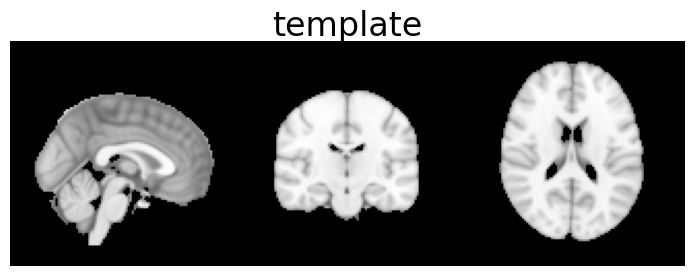

In [9]:
temp = ants.image_read('./Misc/Atlas_brain_2mm.nii')
temp.plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title='template')

In [10]:
s = 2010

In [12]:
sub = folders[s]
print(sub)

sub-NDARINVD4KGD45Y


In [27]:
sub = 'sub-NDARINVDULBXX1K'

In [28]:
safe_mkdir('/scratch/aglinska/ants-workingdir/')

In [29]:
tmp_dir = '/scratch/aglinska/ants-workingdir/'+sub+'/'
safe_mkdir(tmp_dir)
tmp_dir

'/scratch/aglinska/ants-workingdir/sub-NDARINVDULBXX1K/'

In [30]:
anat = ants.image_read(anat_temp.format(sub=sub,ses=ses)) 
seg = ants.image_read(seg_temp.format(sub=sub,ses=ses))

## Plot
anat.plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=sub)
## Plot
anat.plot_ortho(seg,flat=True,xyz_lines=False,orient_labels=False,title='Anat+Segmentation',overlay_alpha=.5)

brain_tissue = (seg.numpy()==1) + (seg.numpy()==2)
brain = anat.copy()
#brain[brain_tissue] = norm_to_0_1(brain[brain_tissue])
brain[~brain_tissue]=0

## Plot
temp.plot_ortho(brain,flat=True,xyz_lines=False,orient_labels=False,overlay_cmap='hot',title='Template + before Rigid')

tx = ants.registration(fixed=temp,moving=brain,type_of_transform='Rigid',outprefix=tmp_dir)

brain_aligned = ants.apply_transforms(fixed=temp,moving=brain,transformlist=tx['fwdtransforms'],interpolator='bSpline') 
anat_aligned = ants.apply_transforms(fixed=temp,moving=anat,transformlist=tx['fwdtransforms'],interpolator='bSpline') 
seg_aligned = ants.apply_transforms(fixed=temp,moving=seg,transformlist=tx['fwdtransforms'],interpolator='nearestNeighbor') 

## Plot
temp.plot_ortho(brain_aligned,flat=True,xyz_lines=False,orient_labels=False,overlay_cmap='hot',title='Template + after Rigid',overlay_alpha=.5)

## Plot
brain_aligned.plot_ortho(brain,flat=True,xyz_lines=False,orient_labels=False,overlay_alpha=.5,overlay_cmap='hot',title='Bain after + before alignment')

resample_params = (64,64,64)

## Tiny brain original
anat_tiny_orig = ants.resample_image(image=anat,resample_params=resample_params,use_voxels=True,interp_type=4)
seg_tiny_orig = ants.resample_image(image=seg,resample_params=resample_params,use_voxels=True,interp_type=1)

brain_tissue_tiny = (seg_tiny_orig.numpy()==1) + (seg_tiny_orig.numpy()==2)
brain_tiny = anat_tiny_orig.copy()
brain_tiny[~brain_tissue_tiny]=0 # Remove non-brain tissue
brain_tiny[brain_tissue_tiny]= norm_to_0_1(brain_tiny[brain_tissue_tiny])

brain_tiny.to_filename(os.path.join(ofdir,sub+'_brain_tiny_orig.nii.gz'))
np.savez_compressed(file=os.path.join(ofdir,sub+'_brain_arr_orig.npz'),arr=brain_tiny.numpy())

## Tiny brain aligned
anat_tiny = ants.resample_image(image=anat_aligned,resample_params=resample_params,use_voxels=True,interp_type=4)
seg_tiny = ants.resample_image(image=seg_aligned,resample_params=resample_params,use_voxels=True,interp_type=1)

brain_tissue_tiny = (seg_tiny.numpy()==1) + (seg_tiny.numpy()==2)
brain_tiny = anat_tiny.copy()
brain_tiny[~brain_tissue_tiny]=0 # Remove non-brain tissue

## Plot
brain_tiny.plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title='Tiny brain final normed')

brain_tiny_normed = brain_tiny.copy()
brain_tiny_normed[brain_tissue_tiny] = norm_to_0_1(brain_tiny_normed[brain_tissue_tiny])
brain_tiny_normed[~brain_tissue_tiny] = 0


brain_arr_tiny = brain_tiny_normed.numpy()
brain_tiny_normed.to_filename(os.path.join(ofdir,sub+'_brain_tiny_aligned.nii.gz'))
np.savez_compressed(file=os.path.join(ofdir,sub+'_brain_arr_aligned.npz'),arr=brain_arr_tiny)

ValueError: File ./Data/ABCD-data-use-T0-fmriprepped/sub-NDARINVDULBXX1K/ses-baselineYear1Arm1/anat/sub-NDARINVDULBXX1K_ses-baselineYear1Arm1_run-01_desc-preproc_T1w.nii.gz does not exist!

In [ ]:
brain_tiny_normed

In [ ]:
brain_arr_tiny.shape

In [ ]:
plt.figure(figsize=np.array((15,5))*.75  )
plt.subplot(1,4,1);plt.imshow(brain_tiny_normed[:,:,32]);plt.axis('off')
plt.subplot(1,4,2);plt.imshow(np.rot90(brain_tiny_normed[:,32,:]));plt.axis('off')
plt.subplot(1,4,3);plt.imshow(np.rot90(brain_tiny_normed[32,:,:]));plt.axis('off')

In [ ]:
plt.figure()
plt.hist(brain_tiny_normed.numpy().flatten())

In [ ]:
shutil.rmtree(tmp_dir) 

In [ ]:
t1 = now()
print(t1-t0)